### Downloading the dataset

In [3]:
!nvidia-smi

Fri Apr  9 14:45:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import shutil
import os
try:
    shutil.rmtree("inaturalist_12K")
except:
    pass

try:
    os.remove("nature_12K.zip")
except:
    pass

try:
    shutil.rmtree("wandb")
except:
    pass

In [9]:
!gdown https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s

Downloading...
From: https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s
To: /content/nature_12K.zip
3.82GB [01:07, 56.4MB/s]


In [10]:
%%capture
!unzip "/content/nature_12K.zip"

In [5]:
%%capture
! pip install wandb

In [11]:
!find . -name "*.DS_Store" -type f -delete

### Importing libraries

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback
from keras.utils.vis_utils import plot_model

### Exploring the data

In [12]:
# list of class names
temp = os.listdir("inaturalist_12K/train")
class_names = [name for name in temp if name != ".DS_Store"]
print("The names of the classes are:")
print(class_names)

num_classes = len(class_names)
print(f"Number of classes = {num_classes}\n")

M = 0
M_test = 0

for each_class in class_names:
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    test_images = os.listdir("inaturalist_12K/val/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    filtered_test_images = list(filter(lambda x: x!=".DS_Store", test_images))
    M = M + len(filtered_train_images)
    M_test = M_test + len(filtered_test_images)

print(f"Total number of training images = {M}")
print(f"Total number of test images = {M_test}\n")

The names of the classes are:
['Fungi', 'Mammalia', 'Aves', 'Mollusca', 'Animalia', 'Reptilia', 'Arachnida', 'Insecta', 'Amphibia', 'Plantae']
Number of classes = 10

Total number of training images = 9999
Total number of test images = 2000



In [13]:
input_image_shape = (224, 224, 3)

### Creating validation set

In [ ]:
# Fraction of images to use in the validationset
validation_split_fraction = 0.1

try:
    shutil.rmtree("inaturalist_12K/validation/")
except:
    pass
    
# Create a new directory for the validation set
os.mkdir("inaturalist_12K/validation/")

for each_class in class_names:
    os.mkdir("inaturalist_12K/validation/"+each_class)
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    count = len(filtered_train_images)
    random.shuffle(filtered_train_images) # Shuffle the training images

    validation_images = filtered_train_images[:round(validation_split_fraction*count)]

    for im in validation_images:
        shutil.move("inaturalist_12K/train/"+each_class+"/"+im, "inaturalist_12K/validation/"+each_class+"/"+im)

### Set up the training, validation and test generators

In [ ]:
def make_generators(train_batch_size, data_aug):
    if data_aug:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    # batch_size for validation and test generator should perfectly divide the total number of examples
    validation_generator = val_datagen.flow_from_directory(
        'inaturalist_12K/validation',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode=None,
        shuffle=False,
        seed=42)
    
    return train_generator, validation_generator, test_generator

### Building the model

In [ ]:
def define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout):
    model = Sequential()
    model.add(Conv2D(num_filters[0], shape_of_filters_conv[0], input_shape=input_image_shape))
    if batch_norm_use:
        model.add(BatchNormalization())
    model.add(Activation(activation_function_conv[0]))
    model.add(MaxPool2D(pool_size=shape_of_filters_pool[0], strides = (2, 2)))

    for i in range(1, 5):
        model.add(Conv2D(num_filters[i], shape_of_filters_conv[i]))
        if batch_norm_use:
            model.add(BatchNormalization())
        model.add(Activation(activation_function_conv[i]))
        model.add(MaxPool2D(pool_size=shape_of_filters_pool[i], strides = (2, 2)))

    model.add(Flatten()) # The flatten layer is essential to convert the feature map into a column vector
    model.add(Dense(fc_layer, activation=activation_function_dense))
    model.add(Dropout(dropout)) # For regularization
    model.add(Dense(10, activation="softmax"))
    return model

In [ ]:
def train_validate_model(train_batch_size, data_aug, activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout):
    
    # Create the data generators
    if data_aug:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode=None,
        shuffle=False,
        seed=42)
    
    # Define the model
    model = define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout)

    # Compute the validation step size
    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        epochs=18,
                        verbose=2)
    
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Training accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Training loss')
    plt.xlabel('Epoch')
    plt.show()
    
    return history, model

In [ ]:
def train_validate_model_wandb():
    # Default values for hyper-parameters
    config_defaults = {
        "data_aug": True,
        "train_batch_size": 128,
        "batch_norm_use": True,
        "dropout": 0,
        "num_filters": [16, 32, 64, 128, 256],
        "fc_layer": 256,
        "shape_of_filters_conv": [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    num_filters = config.num_filters
    data_aug = config.data_aug
    train_batch_size = config.train_batch_size
    batch_norm_use = config.batch_norm_use
    dropout = config.dropout
    fc_layer = config.fc_layer
    shape_of_filters_conv = config.shape_of_filters_conv
    
    # Display the hyperparameters
    run_name = "aug_{}_bs_{}_bn_{}_drop_{}_fc_{}_fil_{}_shape_{}".format(data_aug, train_batch_size, batch_norm_use, dropout, fc_layer, num_filters, shape_of_filters_conv)
    print(run_name)

    # Create the data generators
    train_generator, validation_generator, test_generator = make_generators(train_batch_size, data_aug)
    
    # Define the model
    model = define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout)
    print(model.count_params())

    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
    VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

    # To save the model with best validation accuracy
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        validation_data = validation_generator,
                        validation_steps = VALIDATION_STEP_SIZE,
                        epochs=10, 
                        callbacks=[WandbCallback(data_type="image", generator=validation_generator), earlyStopping, mc],
                        verbose=2)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return history

### Hyperparameter Search using WandB

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: rz78ffyq
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/rz78ffyq


wandb: Agent Starting Run: le672l21 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


aug_True_bs_128_bn_True_drop_0_fc_128_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
113674
Epoch 1/20
70/70 - 241s - loss: 2.3107 - accuracy: 0.1637 - val_loss: 2.3191 - val_accuracy: 0.1000
Epoch 2/20
70/70 - 206s - loss: 2.1509 - accuracy: 0.2303 - val_loss: 2.3774 - val_accuracy: 0.1000
Epoch 3/20
70/70 - 198s - loss: 2.1052 - accuracy: 0.2436 - val_loss: 2.4158 - val_accuracy: 0.0990
Epoch 4/20
70/70 - 197s - loss: 2.0645 - accuracy: 0.2605 - val_loss: 2.4560 - val_accuracy: 0.1100
Epoch 5/20
70/70 - 197s - loss: 2.0341 - accuracy: 0.2766 - val_loss: 2.4483 - val_accuracy: 0.1140
Epoch 6/20
70/70 - 197s - loss: 2.0099 - accuracy: 0.2855 - val_loss: 2.3130 - val_accuracy: 0.1460
Epoch 7/20
70/70 - 197s - loss: 1.9871 - accuracy: 0.2961 - val_loss: 2.1686 - val_accuracy: 0.2270
Epoch 8/20
70/70 - 198s - loss: 1.9726 - accuracy: 0.3

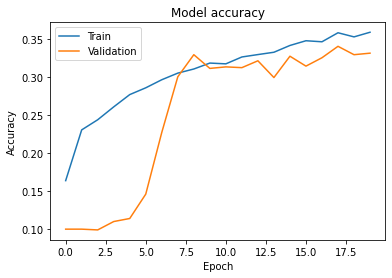

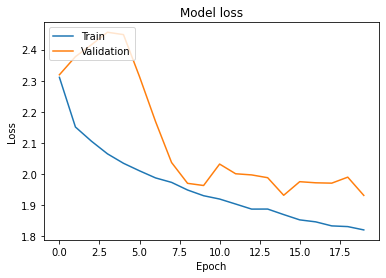

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: eewwcvg7 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0_fc_256_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2099370
Epoch 1/20
35/35 - 196s - loss: 2.2942 - accuracy: 0.1137 - val_loss: 2.2698 - val_accuracy: 0.1700
Epoch 2/20
35/35 - 198s - loss: 2.2484 - accuracy: 0.1671 - val_loss: 2.2145 - val_accuracy: 0.1770
Epoch 3/20
35/35 - 200s - loss: 2.1772 - accuracy: 0.2027 - val_loss: 2.1353 - val_accuracy: 0.2290
Epoch 4/20
35/35 - 195s - loss: 2.1358 - accuracy: 0.2259 - val_loss: 2.1141 - val_accuracy: 0.2500
Epoch 5/20
35/35 - 194s - loss: 2.1039 - accuracy: 0.2398 - val_loss: 2.0722 - val_accuracy: 0.2640
Epoch 6/20
35/35 - 198s - loss: 2.0818 - accuracy: 0.2466 - val_loss: 2.0690 - val_accuracy: 0.2750
Epoch 7/20
35/35 - 194s - loss: 2.0577 - accuracy: 0.2624 - val_loss: 2.0480 - val_accuracy: 0.2780
Epoch 8/20
35/35 - 198s - loss: 2.0459 - accuracy:

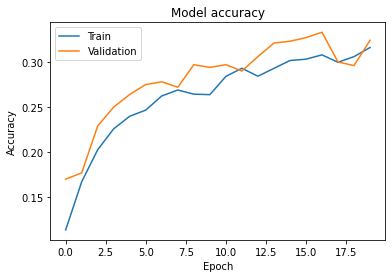

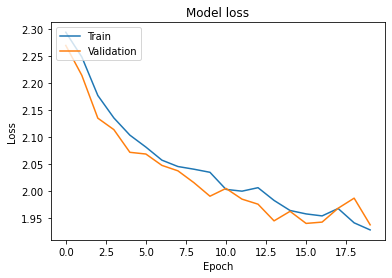

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xy2m946d with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_True_drop_0.2_fc_512_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2366314
Epoch 1/20
35/35 - 196s - loss: 2.2955 - accuracy: 0.2045 - val_loss: 2.3257 - val_accuracy: 0.1150
Epoch 2/20
35/35 - 194s - loss: 2.0775 - accuracy: 0.2598 - val_loss: 2.3891 - val_accuracy: 0.0940
Epoch 3/20
35/35 - 195s - loss: 2.0193 - accuracy: 0.2767 - val_loss: 2.4930 - val_accuracy: 0.1000
Epoch 4/20
35/35 - 196s - loss: 1.9823 - accuracy: 0.3014 - val_loss: 2.4630 - val_accuracy: 0.1310
Epoch 5/20
35/35 - 196s - loss: 1.9411 - accuracy: 0.3139 - val_loss: 2.4962 - val_accuracy: 0.1440
Epoch 6/20
35/35 - 198s - loss: 1.9239 - accuracy: 0.3189 - val_loss: 2.4118 - val_accuracy: 0.1460
Epoch 7/20
35/35 - 197s - loss: 1.9034 - accuracy: 0.3281 - val_loss: 2.4391 - val_accuracy: 0.1580
Epoch 8/20
35/35 - 195s - loss: 1.8661 - accuracy

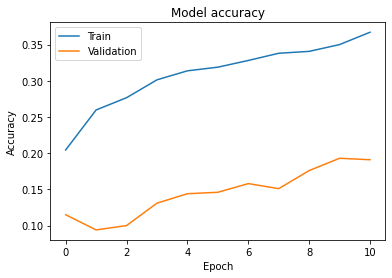

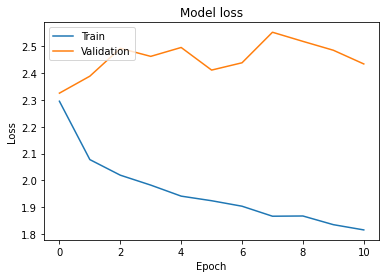

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 67wqxzgd with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
471546
Epoch 1/20


Run 67wqxzgd errored: ResourceExhaustedError()
wandb: ERROR Run 67wqxzgd errored: ResourceExhaustedError()
wandb: Agent Starting Run: ebptnkbb with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0_fc_128_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1215210
Epoch 1/20
35/35 - 114s - loss: 2.2424 - accuracy: 0.2191 - val_loss: 2.3075 - val_accuracy: 0.1020
Epoch 2/20
35/35 - 112s - loss: 1.9398 - accuracy: 0.3164 - val_loss: 2.3421 - val_accuracy: 0.1000
Epoch 3/20
35/35 - 111s - loss: 1.8227 - accuracy: 0.3607 - val_loss: 2.4092 - val_accuracy: 0.1010
Epoch 4/20
35/35 - 112s - loss: 1.7047 - accuracy: 0.4065 - val_loss: 2.4274 - val_accuracy: 0.1080
Epoch 5/20
35/35 - 112s - loss: 1.5930 - accuracy: 0.4599 - val_loss: 2.5114 - val_accuracy: 0.1100
Epoch 6/20
35/35 - 113s - loss: 1.4919 - accuracy: 0.5039 - val_loss: 2.5492 - val_accuracy: 0.1180
Epoch 7/20
35/35 - 112s - loss: 1.3796 - accuracy: 0.5472 - val_loss: 2.4893 - val_accuracy: 0.1180
Epoch 8/20
35/35 - 112s - loss: 1.2728 - accuracy:

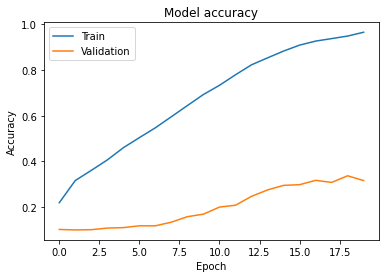

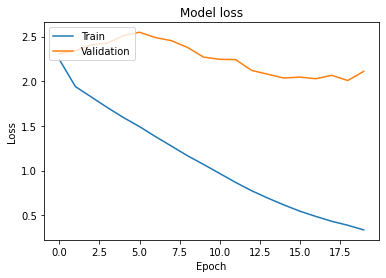

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: muoxykfd with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8127818
Epoch 1/20
70/70 - 201s - loss: 2.2323 - accuracy: 0.1717 - val_loss: 2.1515 - val_accuracy: 0.2240
Epoch 2/20
70/70 - 196s - loss: 2.1258 - accuracy: 0.2226 - val_loss: 2.0595 - val_accuracy: 0.2600
Epoch 3/20
70/70 - 196s - loss: 2.0763 - accuracy: 0.2545 - val_loss: 2.0617 - val_accuracy: 0.2640
Epoch 4/20
70/70 - 192s - loss: 2.0449 - accuracy: 0.2647 - val_loss: 1.9936 - val_accuracy: 0.2950
Epoch 5/20
70/70 - 196s - loss: 2.0191 - accuracy: 0.2789 - val_loss: 1.9675 - val_accuracy: 0.2950
Epoch 6/20
70/70 - 195s - loss: 1.9922 - accuracy: 0.2932 - val_loss: 1.9522 - val_accuracy: 0.3120
Epoch 7/20
70/70 - 196s - loss: 1.9652 - accuracy: 0.3074 - val_loss: 1.9216 - val_accuracy: 0.3380
Epoch 8/20
70/70 - 195s - loss: 1.9408 - accura

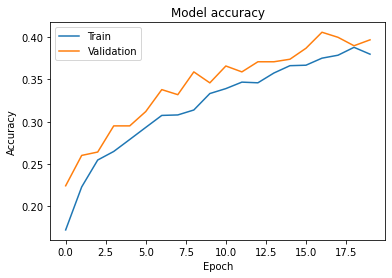

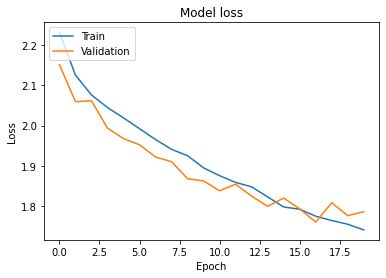

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: uly61d0a with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.1_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
192650
Epoch 1/20
35/35 - 117s - loss: 2.4947 - accuracy: 0.1195 - val_loss: 2.3070 - val_accuracy: 0.1080
Epoch 2/20
35/35 - 114s - loss: 2.2347 - accuracy: 0.1967 - val_loss: 2.3247 - val_accuracy: 0.1040
Epoch 3/20
35/35 - 113s - loss: 2.1226 - accuracy: 0.2456 - val_loss: 2.3527 - val_accuracy: 0.1170
Epoch 4/20
35/35 - 113s - loss: 2.0451 - accuracy: 0.2690 - val_loss: 2.3741 - val_accuracy: 0.1240
Epoch 5/20
35/35 - 113s - loss: 1.9857 - accuracy: 0.2985 - val_loss: 2.4106 - val_accuracy: 0.1080
Epoch 6/20
35/35 - 112s - loss: 1.9485 - accuracy: 0.3165 - val_loss: 2.4312 - val_accuracy: 0.1330
Epoch 7/20
35/35 - 112s - loss: 1.9027 - accuracy: 0.3330 - val_loss: 2.4511 - val_accuracy: 0.1200
Epoch 8/20
35/35 - 114s - loss: 1.8571 - accuracy: 

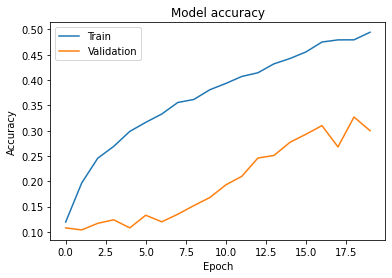

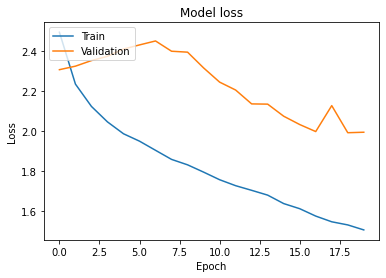

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8rd8p73m with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0_fc_512_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1090810
Epoch 1/20


In [ ]:
# These are the hyperparameters that we do not sweep over
activation_function_conv = ["relu", "relu", "relu", "relu", "relu"]
activation_function_dense = "relu"
shape_of_filters_pool = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]

# Sweep configuration
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [128, 256]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [32, 32, 32, 32, 32],
                       [256, 128, 64, 32, 16], [64, 128, 256, 512, 1024], [128, 64, 32, 16, 8]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}

# Generates a sweep id
sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=100)

### Training a model with the best set of hyperparameters

In [90]:
# Transferring the validation images back into the training set
for each_class in class_names:
    # Get the validation images of each class
    validation_images = os.listdir("inaturalist_12K/validation/"+each_class)
    filtered_vaidation_images = list(filter(lambda x: x!=".DS_Store", validation_images))

    for im in filtered_vaidation_images:
        # Transfer images from the validation to training folders
        shutil.move("inaturalist_12K/validation/"+each_class+"/"+im, "inaturalist_12K/train/"+each_class+"/"+im)

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/18
78/78 - 207s - loss: 2.2054 - accuracy: 0.2338
Epoch 2/18
78/78 - 204s - loss: 2.0025 - accuracy: 0.2943
Epoch 3/18
78/78 - 202s - loss: 1.9280 - accuracy: 0.3175
Epoch 4/18
78/78 - 201s - loss: 1.8765 - accuracy: 0.3375
Epoch 5/18
78/78 - 204s - loss: 1.8417 - accuracy: 0.3504
Epoch 6/18
78/78 - 202s - loss: 1.7944 - accuracy: 0.3644
Epoch 7/18
78/78 - 206s - loss: 1.7851 - accuracy: 0.3704
Epoch 8/18
78/78 - 206s - loss: 1.7517 - accuracy: 0.3852
Epoch 9/18
78/78 - 205s - loss: 1.7111 - accuracy: 0.4024
Epoch 10/18
78/78 - 203s - loss: 1.6925 - accuracy: 0.4082
Epoch 11/18
78/78 - 203s - loss: 1.6720 - accuracy: 0.4104
Epoch 12/18
78/78 - 203s - loss: 1.6589 - accuracy: 0.4167
Epoch 13/18
78/78 - 202s - loss: 1.6328 - accuracy: 0.4230
Epoch 14/18
78/78 - 201s - loss: 1.6232 - accuracy: 0.4271
Epoch 15/18
78/78 - 202s - loss: 1.6015 - accuracy: 0.4350
Epoch 16/18
78/78 - 202s - loss: 1.592

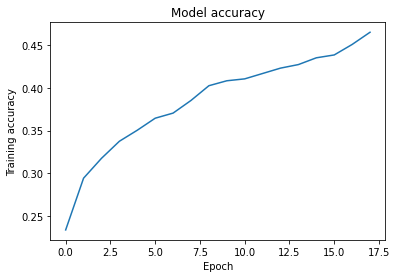

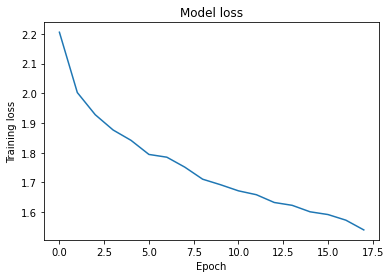

INFO:tensorflow:Assets written to: best_model_dl_2/assets


In [ ]:
# These are the hyperparameters that we do not sweep over
activation_function_conv = ["relu", "relu", "relu", "relu", "relu"]
activation_function_dense = "relu"
shape_of_filters_pool = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]

# Best values of hyperparameters chosen using wandb sweeps
data_aug = True
train_batch_size = 128
batch_norm_use = True
dropout = 0.1

# Number of filters in each layer
num_filters = [32, 64, 128, 256, 512]
# Number of neurons in the dense/fully connected layer
fc_layer = 512
# Shape of the filters used in each of the five layers
shape_of_filters_conv = [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]

# Training the model
history, model = train_validate_model(train_batch_size,
                               data_aug,
                               activation_function_conv,
                               activation_function_dense,
                               num_filters,
                               shape_of_filters_conv, 
                               shape_of_filters_pool,
                               batch_norm_use,
                               fc_layer,
                               dropout)

# Save the model
model.save("best_model_dl_2")

In [ ]:
# Saving the model in H5 format
model.save("best_cnn_model.h5")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# model.save("/content/drive/My Drive/DataAnalyticsLAB/Project_Dataset/best_model_dl_2")

Mounted at /content/drive


### Model Summary

In [ ]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
activation_20 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
activation_21 (Activation)   (None, 109, 109, 64)     

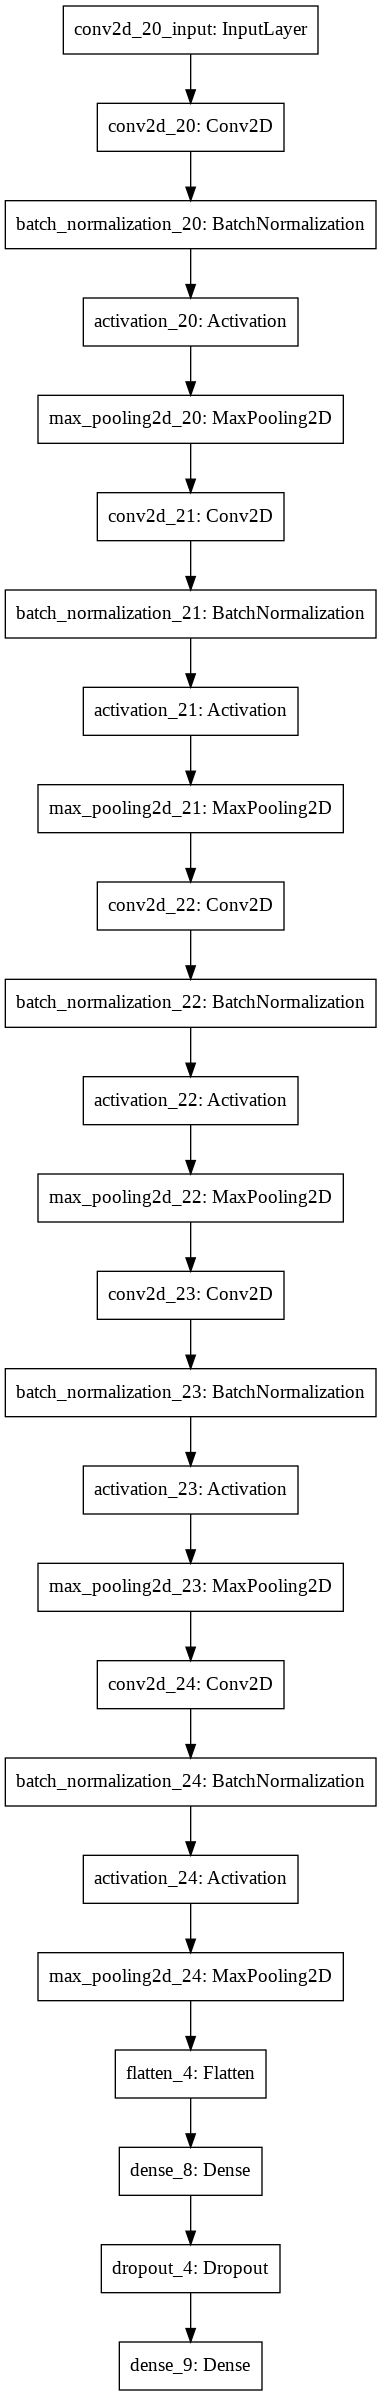

In [ ]:
plot_model(model)

## Testing and Prediction Section

In [ ]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback
from keras.utils.vis_utils import plot_model

### Loading the saved model

In [1]:
!gdown https://drive.google.com/uc?id=1PDD1yFroe89wlwqQB_--bq3mDxwvTHyY

Downloading...
From: https://drive.google.com/uc?id=1PDD1yFroe89wlwqQB_--bq3mDxwvTHyY
To: /content/best_cnn_model.h5
101MB [00:01, 82.9MB/s] 


In [7]:
# Load the saved model
model = load_model("best_cnn_model.h5")
# Input image shape
input_image_shape = (224, 224, 3)

### Predictions

##### Training set

In [15]:
# Predictions on the training set
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=128,
        class_mode='categorical',
        shuffle=True,
        seed=42)

# Evaluation on the training set
loss, accuracy = model.evaluate(train_generator) 
print(f"Training accuracy = {accuracy*100} %")

Found 9999 images belonging to 10 classes.
79/79 [==============================] - 143s 1s/step - loss: 1.7575 - accuracy: 0.4260
Training accuracy = 42.60426163673401 %


**The training set accuracy for the best model is 42.60426163673401 %**

##### Test set

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=False,
        seed=42)

test_predictions = np.argmax(model.predict(test_generator), axis=-1)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy = {test_accuracy*100} %")

Found 2000 images belonging to 10 classes.
20/20 [==============================] - 21s 1s/step - loss: 1.9815 - accuracy: 0.3760
Test accuracy = 37.59999871253967 %


**The test accuracy for the best model is 37.59999871253967 %**

### Log Sample images from the test set.

In [108]:
# Initialize the wandb run
wandb.init(project="dl_assignment_2", entity="ee17b154tony", name="assignment_2_log_test_images")




True Label :Amphibia



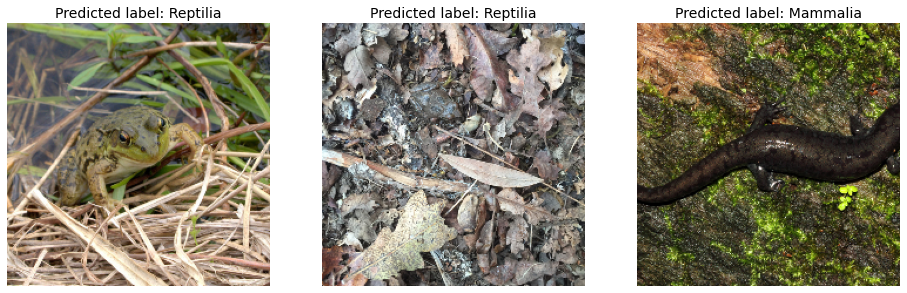




True Label :Animalia



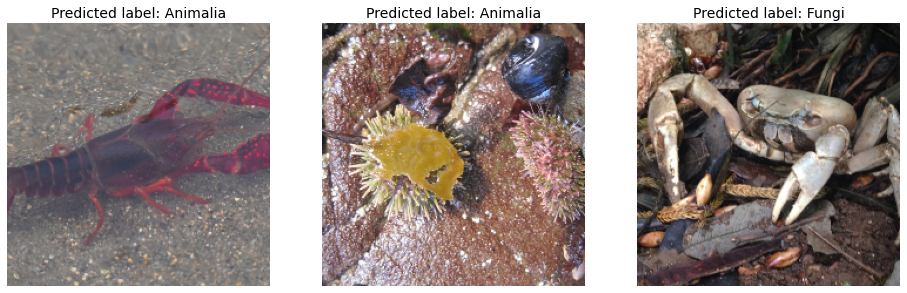




True Label :Arachnida



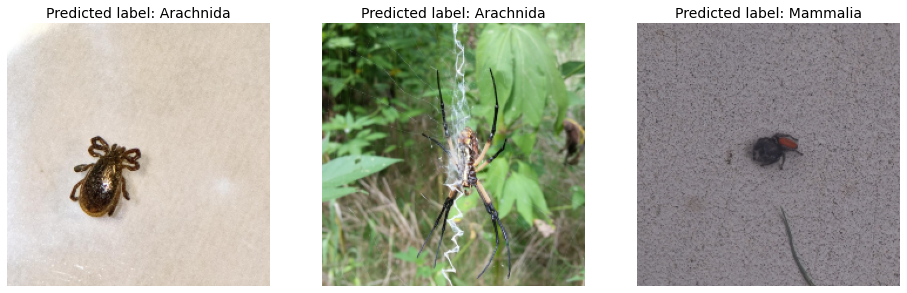




True Label :Aves



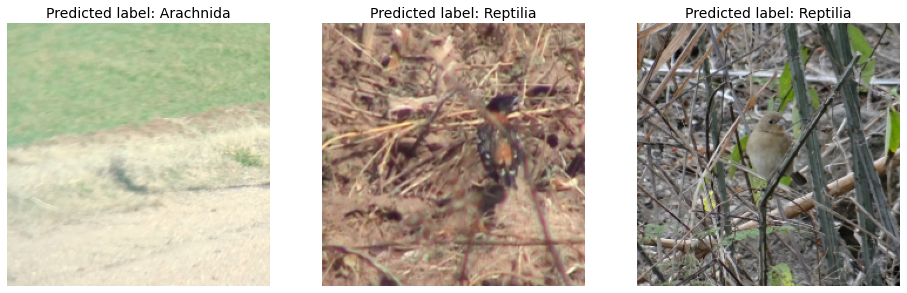




True Label :Fungi



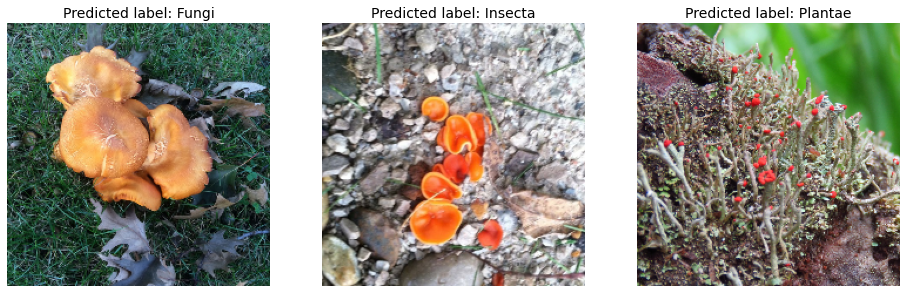




True Label :Insecta



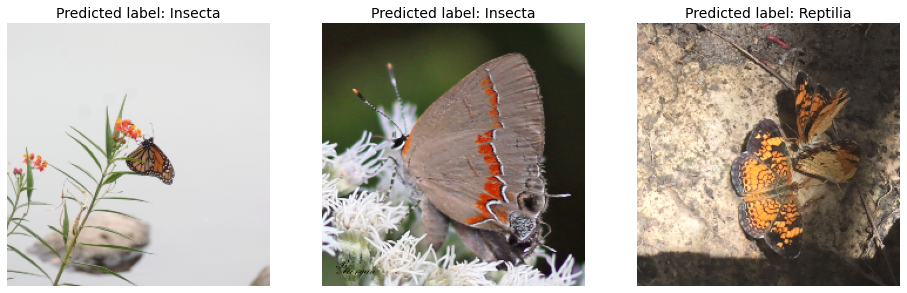




True Label :Mammalia



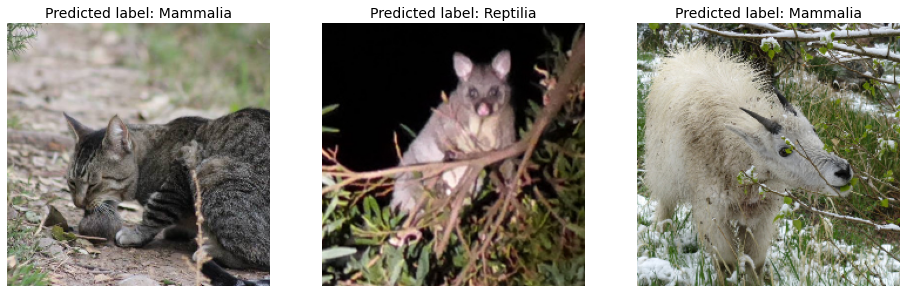




True Label :Mollusca



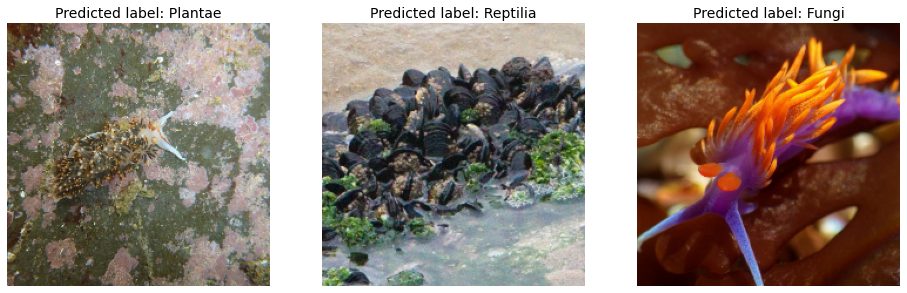




True Label :Plantae



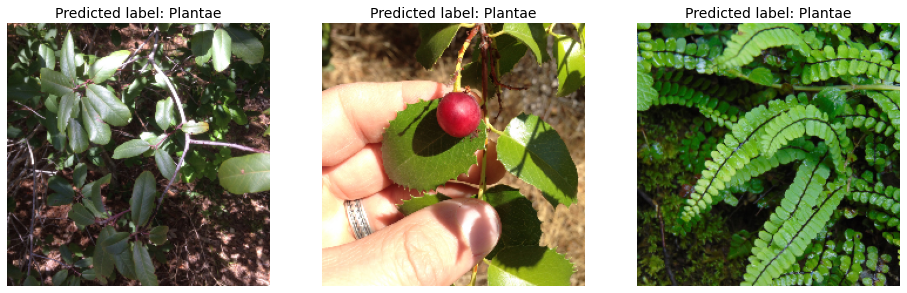




True Label :Reptilia



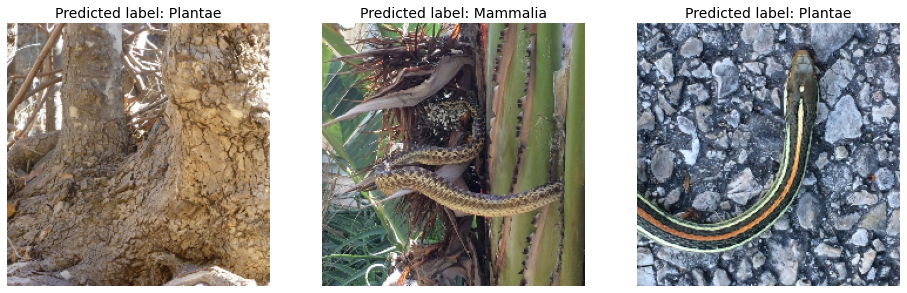

In [109]:
# Retrieve class names in alphabetical order
class_names_dict = train_generator.class_indices
class_names = class_names_dict.keys()
index_to_name = dict([(class_names_dict[key], key) for key in class_names_dict])

sample_images = []
for class_name in class_names:
    num_test_images = len(os.listdir("inaturalist_12K/val/"+class_name))
    test_images = os.listdir("inaturalist_12K/val/"+class_name)
    random_indices = np.random.randint(0, num_test_images, 3)
    print(f"\n\n\nTrue Label :{class_name}\n")
    plt.figure(figsize=(16, 5))
    for i, ind in enumerate(random_indices):
        image = plt.imread("inaturalist_12K/val/"+class_name+"/"+test_images[ind])
        # Resize input image to the model input shape
        resized_image = keras.preprocessing.image.smart_resize(image, input_image_shape[:2])/255.0
        # Predict the class
        pred = np.argmax(model.predict(np.array([resized_image])), axis=-1)[0]
        # Convert the index to the class label
        predicted_class = index_to_name[pred]
        plt.subplot(1, 3, i+1)
        plt.imshow(resized_image)
        plt.axis("off")
        plt.title(f"Predicted label: {predicted_class}", size=14)
    wandb.log({f"True Label: {class_name}": plt})
    plt.show()

### Visualizing Filters

In [150]:
layer = model.layers[0]
filters, biases = layer.get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

num_filters = filters.shape[-1]

print(f"Shape of each filter = {filters.shape[:-1]}")
print(f"Number of filters = {num_filters}")

Shape of each filter = (3, 3, 3)
Number of filters = 32


In the below cell, we have plotted the filters. Each filter of the first convolutional layer is of shape (3, 3, 3). We have plotted each channel of the filter separately. Each row corresponds to the 3 channels in one filter. There are 32 filters in all (in the first convolutional layer).

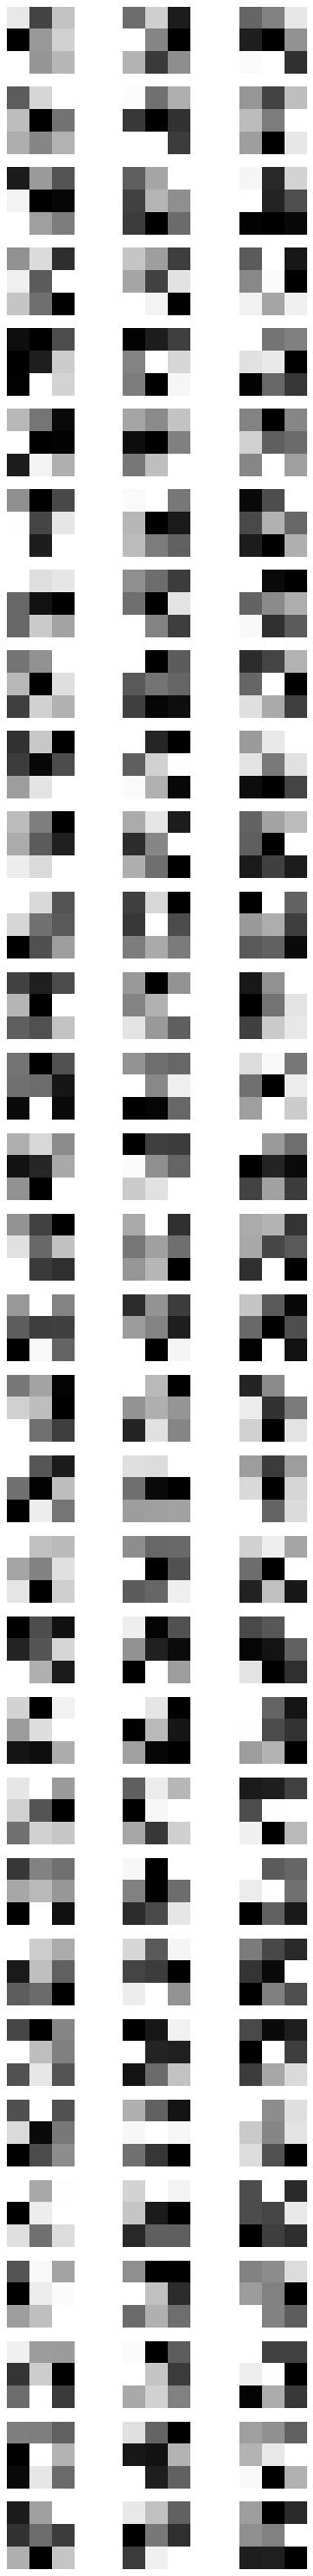

In [158]:
k = 1
plt.figure(figsize=(6, 48))
for i in range(num_filters):
    for j in range(3):
        f = filters[:, :, j, i]
        plt.subplot(num_filters, 3, k)
        k = k + 1
        plt.imshow(f, cmap="gray")
        plt.axis("off")
plt.show()